**Second Most Frequently Seen Bird**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import GRU, Dense
import time


file_path = "birds_observation_data_with_index.csv"
df = pd.read_csv(file_path)

# Most frequent bird
bird_counts = df['Bird Name'].value_counts()
most_frequent_bird = bird_counts.index[1]
bird_data = df[df['Bird Name'] == most_frequent_bird]
bird_trend = bird_data.groupby('Date Index')['Number of Birds'].sum()
values = bird_trend.values.astype('float32').reshape(-1, 1)
print("Most frequently seen bird:", most_frequent_bird)

print(values.mean())

# Normalization
values_log = np.log1p(values)  
values_scaled = values_log

Most frequently seen bird: Yellow-vented Bulbul
22.540697


In [2]:
# window_size = 5
# window_size = 10
# window_size = 20
window_size = 25
# window_size = 30
# window_size = 50

# Sliding Window For Multistep Forecast
def create_multistep_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size]) 
        Y.append(data[i + window_size]) 
    return np.array(X), np.array(Y)

X, Y = create_multistep_dataset(values_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to (samples, time steps, features)

c:\Users\tsimi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training time: 103.47 seconds


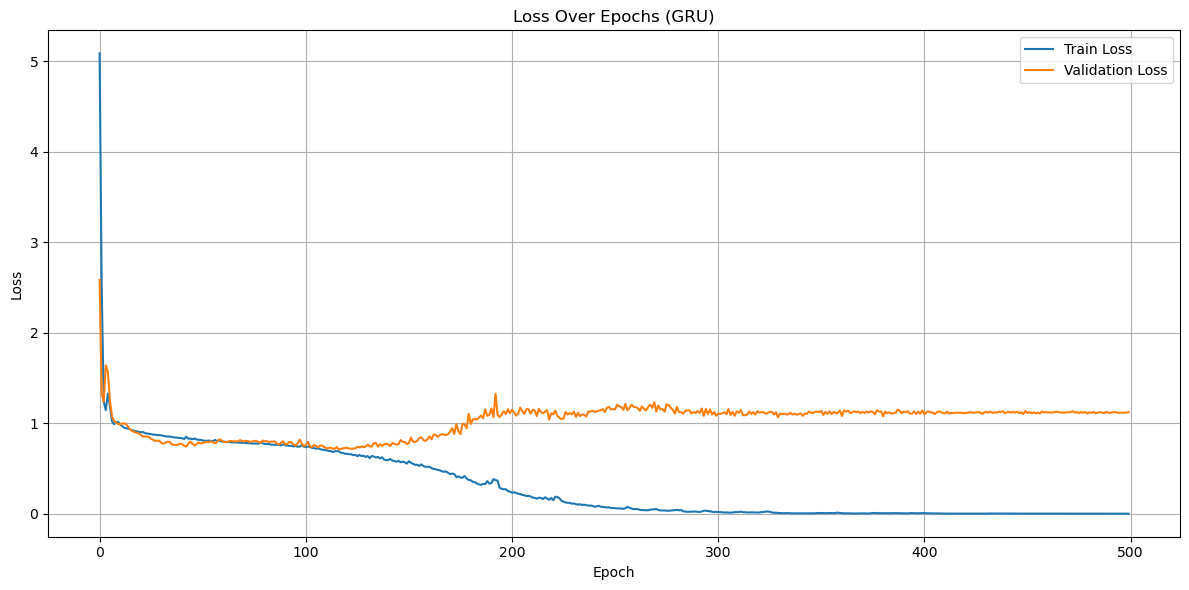

In [3]:
# Train/Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

start = time.time()

model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(window_size, 1)))
model.add(GRU(32)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, 
                    Y_train, 
                    epochs=500, 
                    verbose=0, 
                    validation_data=(X_test, Y_test)
                    )


print(f"Training time: {time.time() - start:.2f} seconds")

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Save Model**

In [ ]:
# model.save('GRU_bird_model.h5')
# print("Model saved as GRU_bird_model.h5")

**Load Saved Model**

In [ ]:
from tensorflow.keras.models import load_model

# model = load_model('GRU_bird_model.h5')

# **Forecasting for Future Trend**

## **window size of 5**

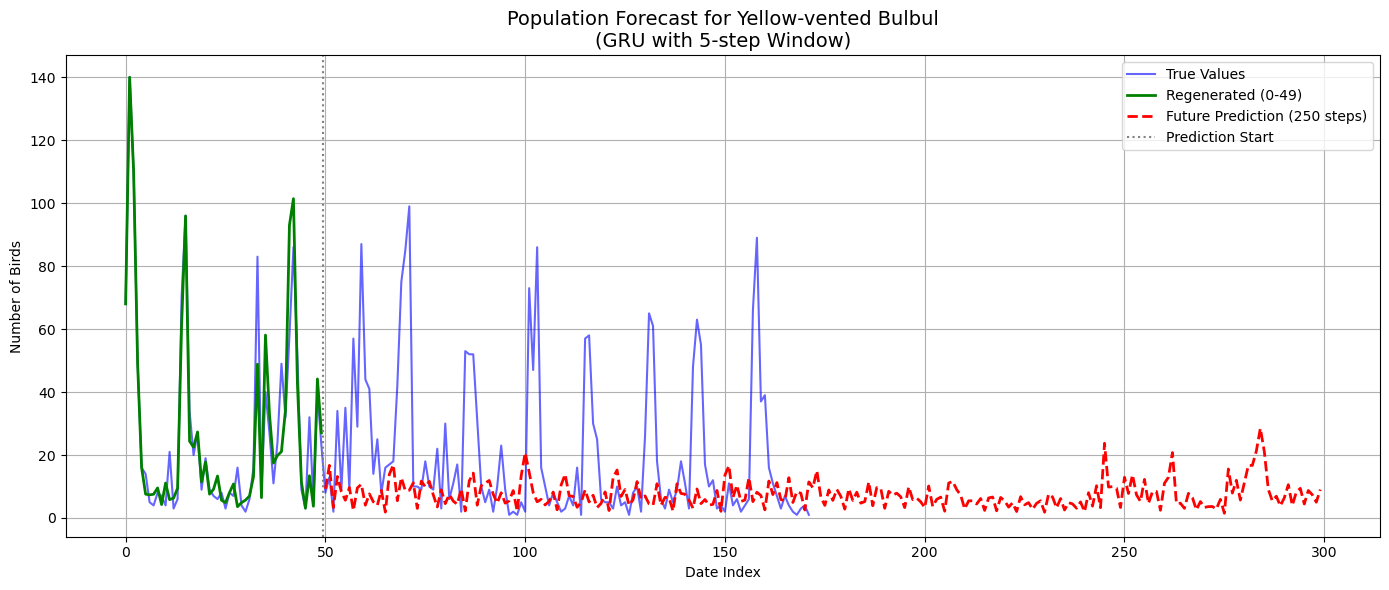

Model Performance Metrics of GRU with 5-step Window:
MSE: 39.1833
RMSE: 6.2597
MAE: 1.9872


In [26]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

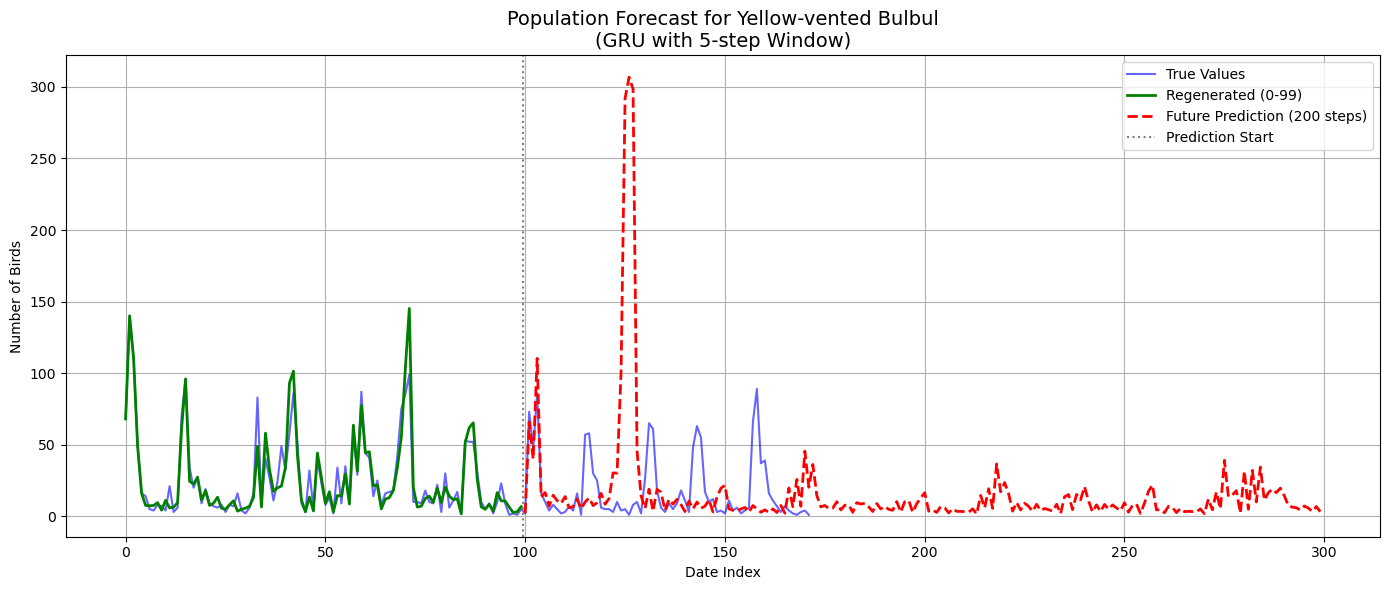

Model Performance Metrics of GRU with 5-step Window:
MSE: 113.8467
RMSE: 10.6699
MAE: 6.7048


In [27]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

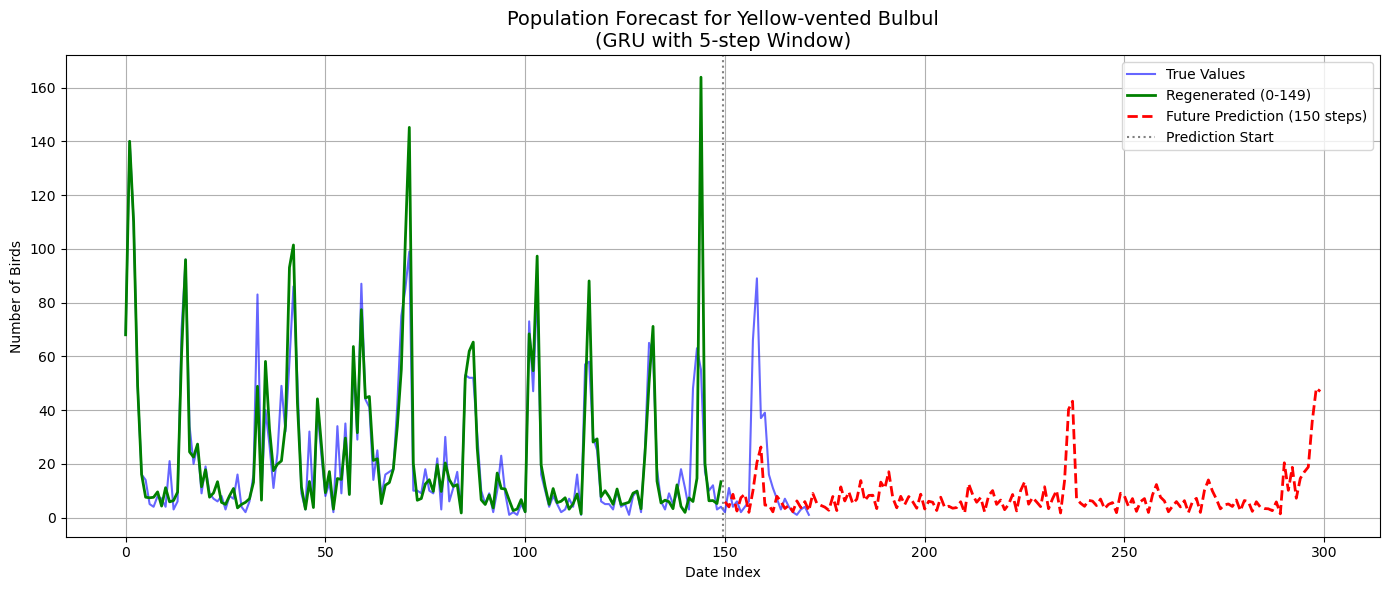

Model Performance Metrics of GRU with 5-step Window:
MSE: 102.1550
RMSE: 10.1072
MAE: 6.3109


In [28]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


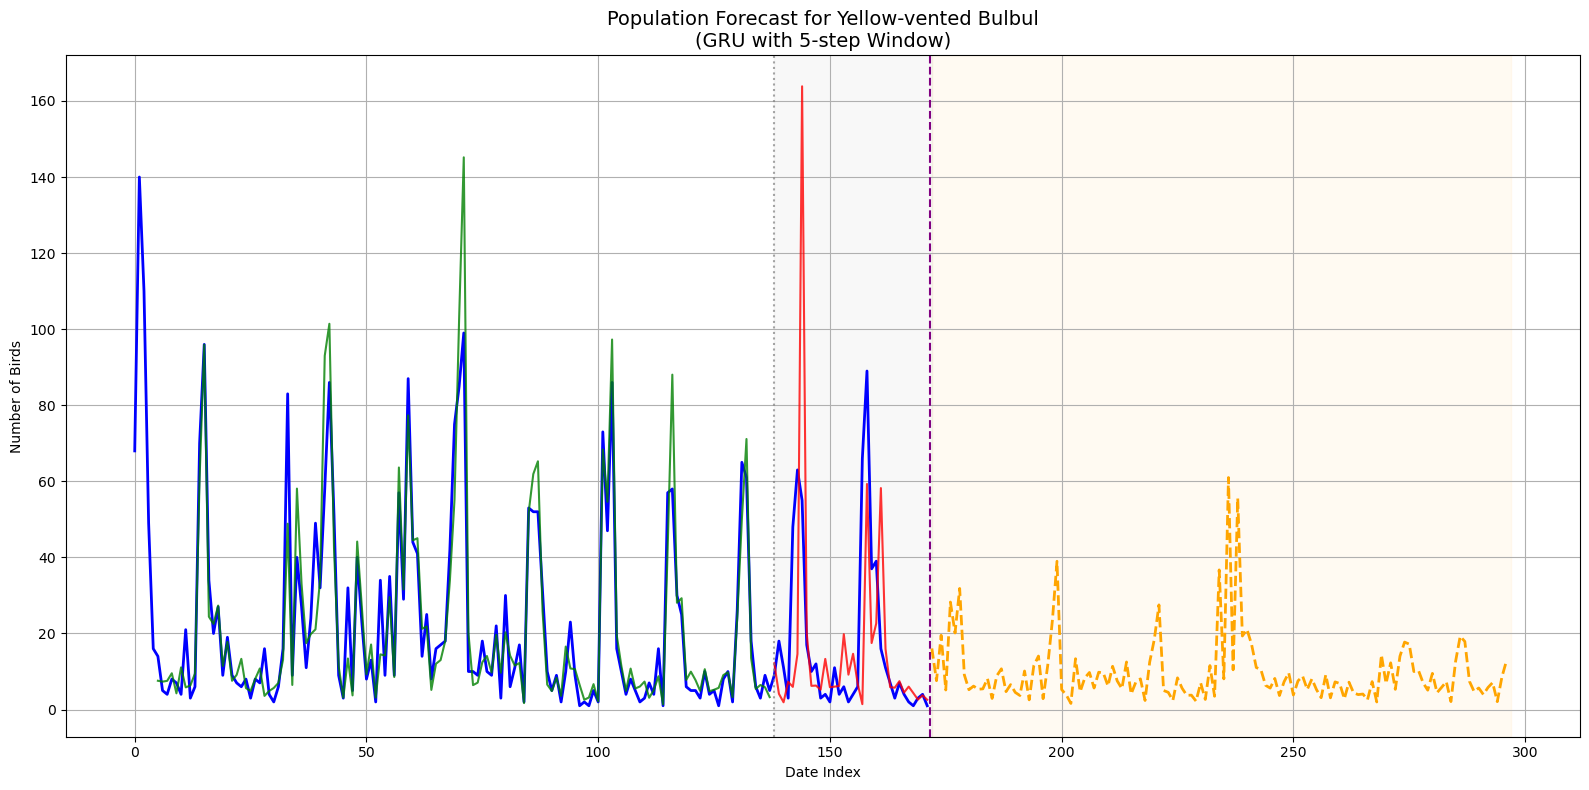


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 9.35
Test RMSE: 26.76
Training MAE: 5.75
Test MAE: 14.38


In [29]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))


print("\nModel Performance Metrics of GRU with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [30]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 16.07
Step 2: 7.58
Step 3: 19.53
Step 4: 5.14
Step 5: 28.26
Step 6: 20.14
Step 7: 31.84
Step 8: 9.14
Step 9: 5.22
Step 10: 6.16
Step 11: 5.34
Step 12: 5.44
Step 13: 8.13
Step 14: 2.93
Step 15: 8.84
Step 16: 10.72
Step 17: 4.71
Step 18: 6.55
Step 19: 4.50
Step 20: 3.69
Step 21: 10.13
Step 22: 2.55
Step 23: 11.57
Step 24: 14.06
Step 25: 2.86
Step 26: 11.59
Step 27: 23.32
Step 28: 38.98
Step 29: 5.25
Step 30: 3.85
Step 31: 1.61
Step 32: 13.36
Step 33: 4.71
Step 34: 8.32
Step 35: 9.74
Step 36: 5.67
Step 37: 9.82
Step 38: 9.61
Step 39: 6.21
Step 40: 11.37
Step 41: 7.52
Step 42: 5.50
Step 43: 12.51
Step 44: 4.09
Step 45: 7.19
Step 46: 8.06
Step 47: 2.39
Step 48: 12.48
Step 49: 18.46
Step 50: 27.52
Step 51: 5.01
Step 52: 4.53
Step 53: 2.40
Step 54: 8.33
Step 55: 5.58
Step 56: 3.75
Step 57: 3.78
Step 58: 2.21
Step 59: 6.98
Step 60: 2.66
Step 61: 11.56
Step 62: 3.50
Step 63: 36.71
Step 64: 8.06
Step 65: 61.00
Step 66: 10.45
Step 67: 55.58
Step 68: 19.34
S

## **window size of 10**

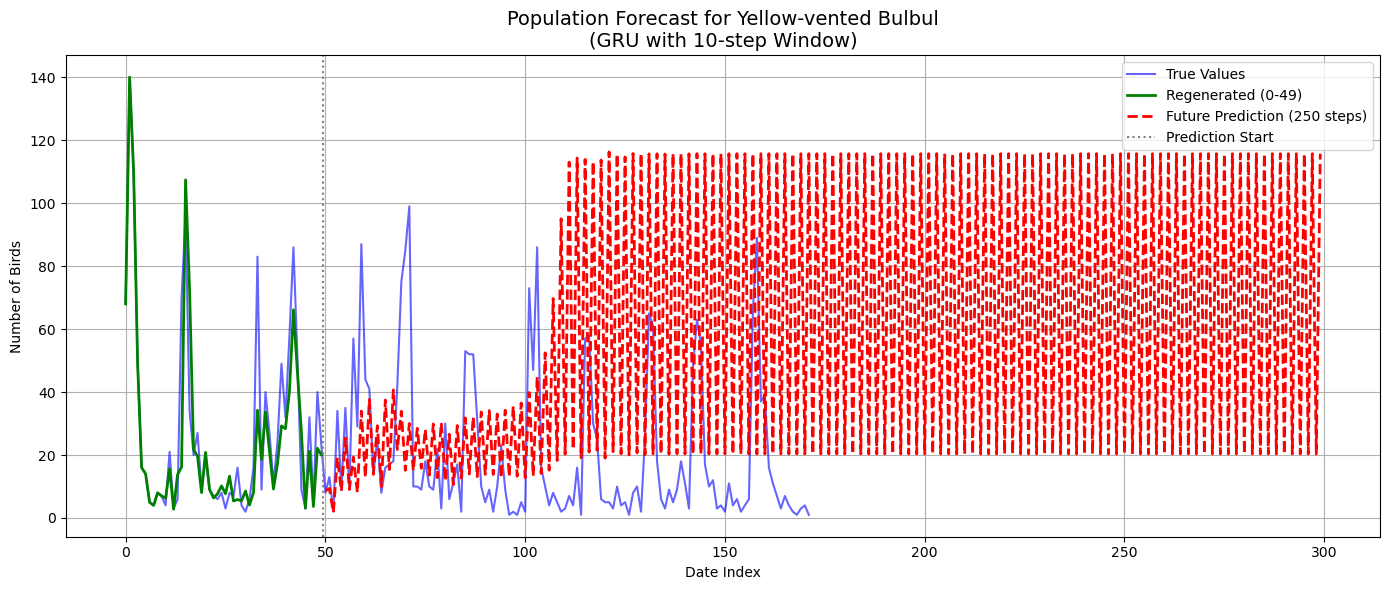

Model Performance Metrics of GRU with 10-step Window:
MSE: 236.4646
RMSE: 15.3774
MAE: 9.2905


In [5]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

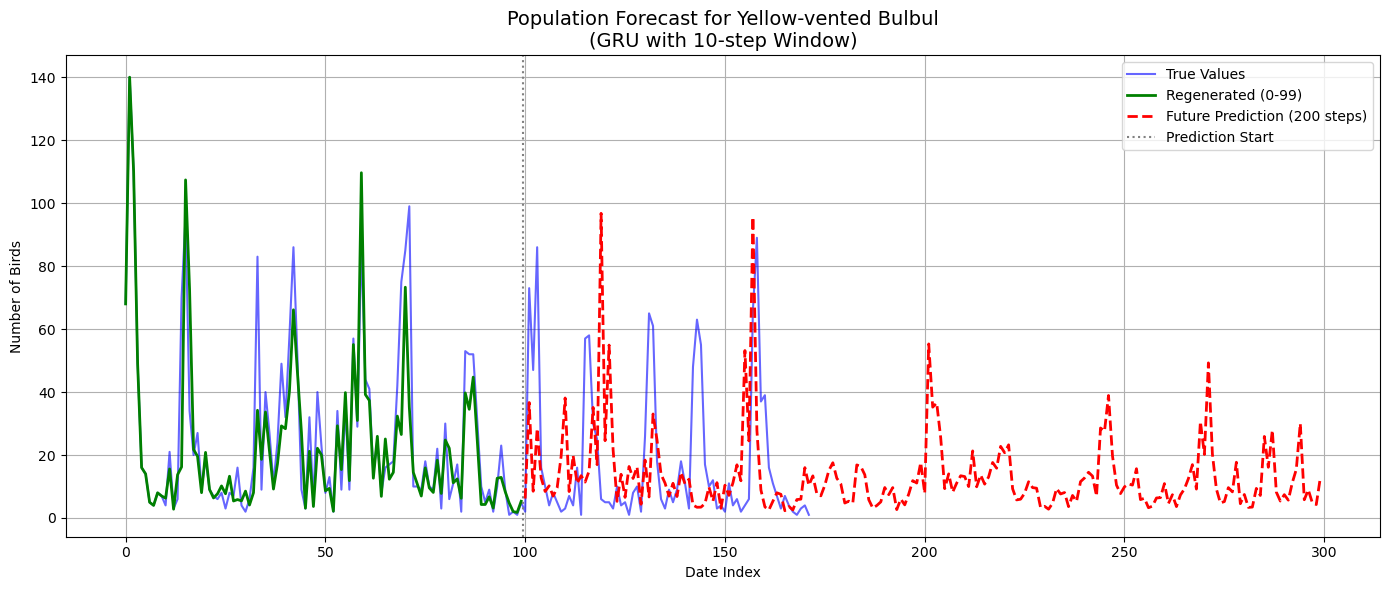

Model Performance Metrics of GRU with 10-step Window:
MSE: 200.2309
RMSE: 14.1503
MAE: 7.8431


In [6]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

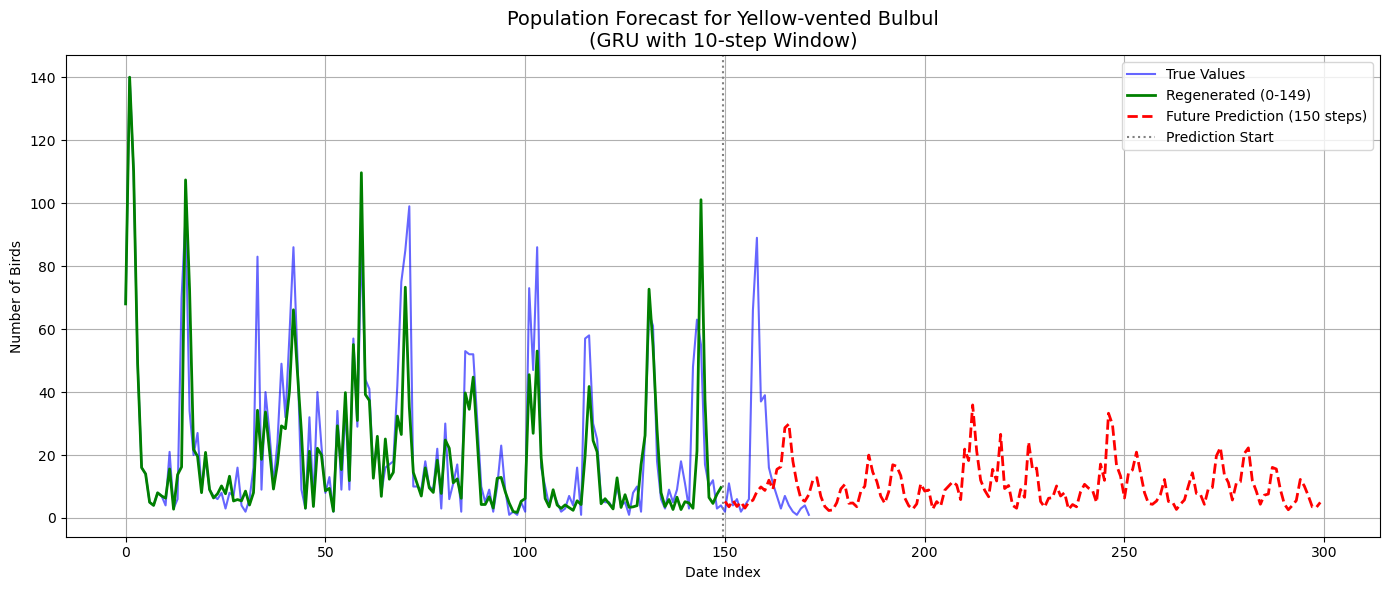

Model Performance Metrics of GRU with 10-step Window:
MSE: 209.8210
RMSE: 14.4852
MAE: 8.2376


In [7]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


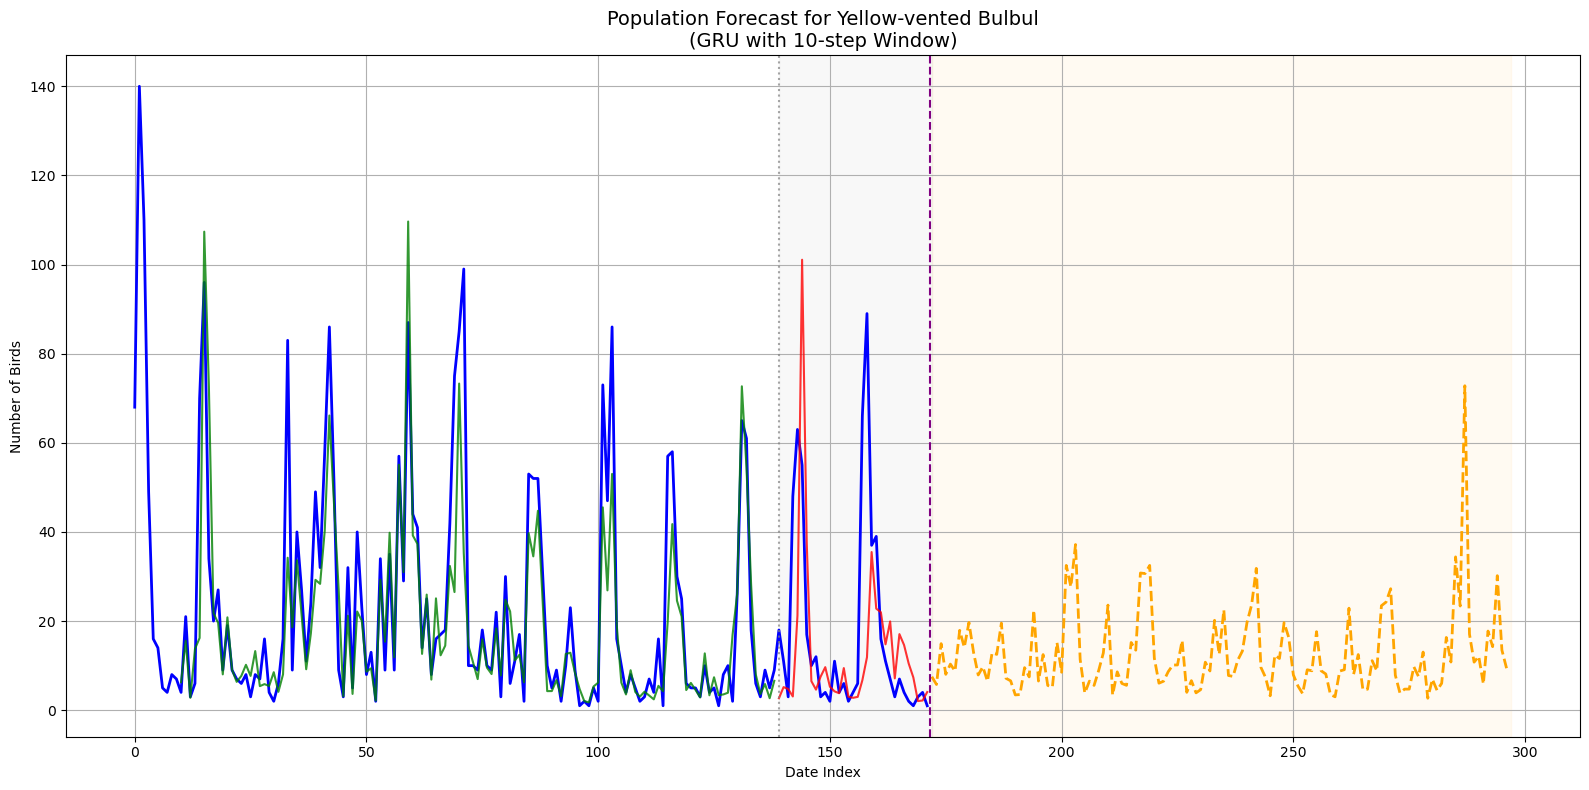


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 13.26
Test RMSE: 22.75
Training MAE: 7.41
Test MAE: 13.29


In [8]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))


print("\nModel Performance Metrics of GRU with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [9]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 7.51
Step 2: 5.77
Step 3: 14.94
Step 4: 8.05
Step 5: 10.35
Step 6: 8.78
Step 7: 17.92
Step 8: 14.10
Step 9: 19.69
Step 10: 12.95
Step 11: 7.90
Step 12: 9.73
Step 13: 6.51
Step 14: 12.89
Step 15: 12.53
Step 16: 19.55
Step 17: 7.16
Step 18: 6.59
Step 19: 3.43
Step 20: 3.51
Step 21: 9.54
Step 22: 7.48
Step 23: 22.47
Step 24: 6.54
Step 25: 12.48
Step 26: 5.56
Step 27: 5.16
Step 28: 15.18
Step 29: 8.52
Step 30: 32.49
Step 31: 27.69
Step 32: 37.17
Step 33: 11.37
Step 34: 3.85
Step 35: 6.52
Step 36: 5.57
Step 37: 8.94
Step 38: 12.85
Step 39: 23.59
Step 40: 3.42
Step 41: 8.60
Step 42: 6.00
Step 43: 5.58
Step 44: 15.19
Step 45: 13.47
Step 46: 30.79
Step 47: 30.66
Step 48: 32.49
Step 49: 11.69
Step 50: 6.07
Step 51: 6.51
Step 52: 8.65
Step 53: 10.15
Step 54: 10.15
Step 55: 15.64
Step 56: 4.01
Step 57: 6.63
Step 58: 3.90
Step 59: 4.61
Step 60: 10.77
Step 61: 8.81
Step 62: 20.17
Step 63: 12.53
Step 64: 22.51
Step 65: 7.78
Step 66: 7.58
Step 67: 11.23
Step 68

## **window size of 20**

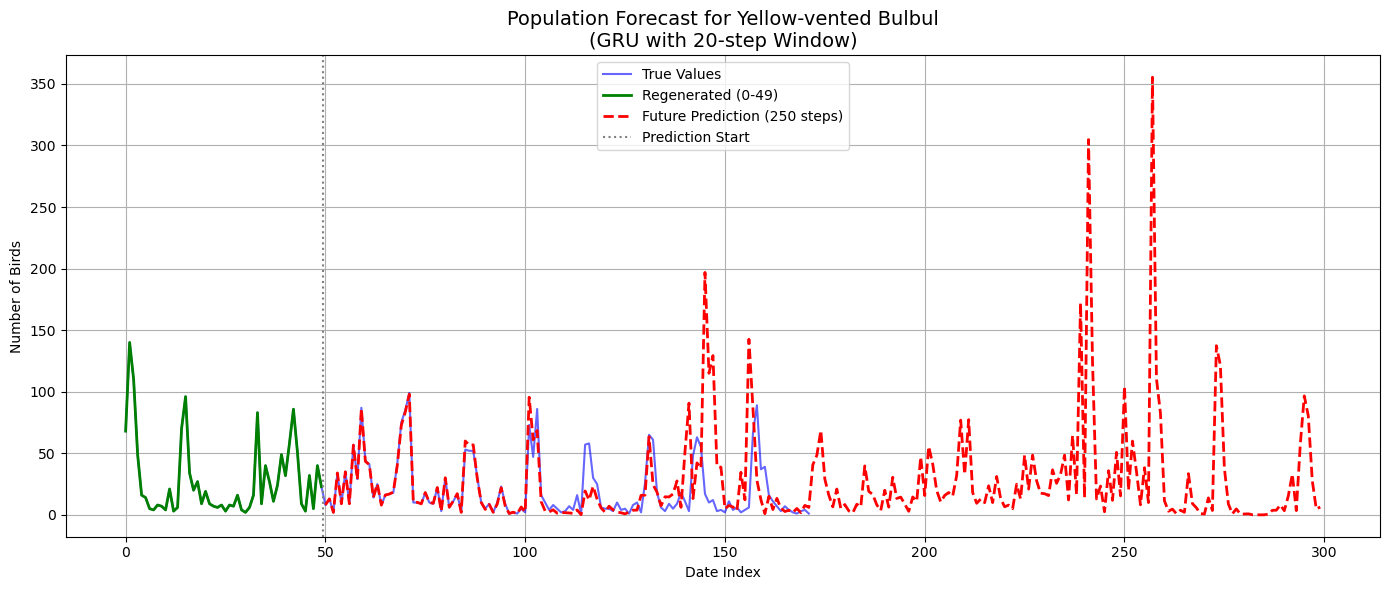

Model Performance Metrics of GRU with 20-step Window:
MSE: 0.0045
RMSE: 0.0671
MAE: 0.0403


In [6]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

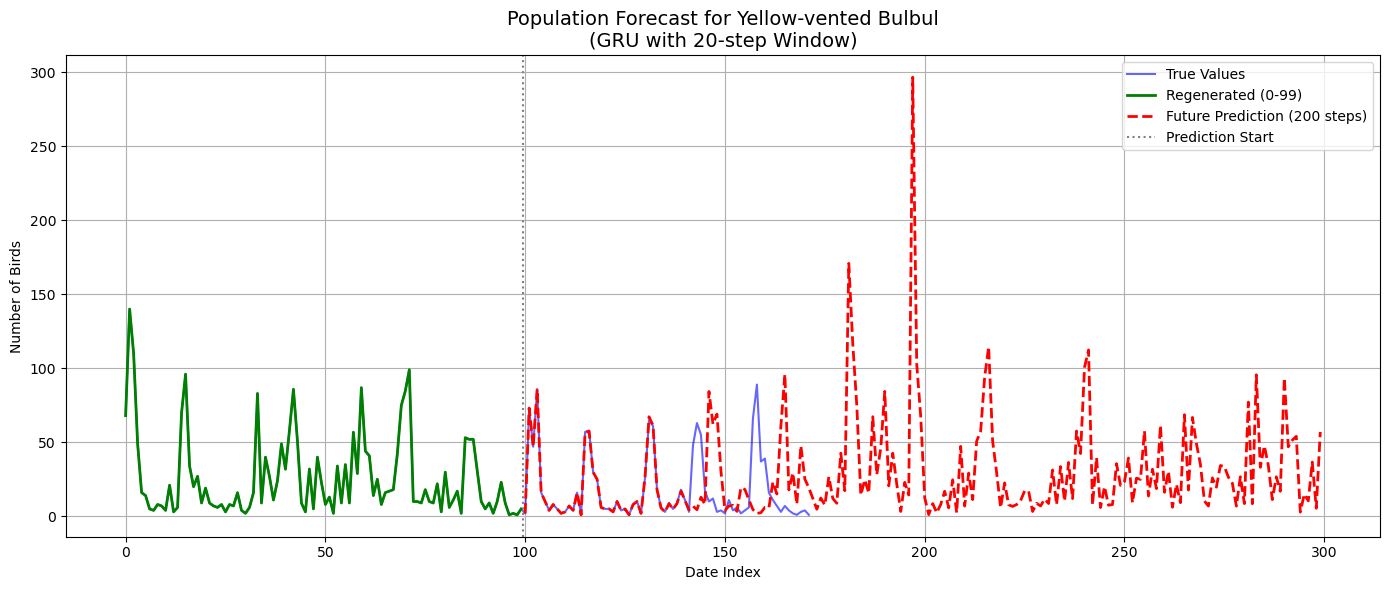

Model Performance Metrics of GRU with 20-step Window:
MSE: 0.0070
RMSE: 0.0835
MAE: 0.0467


In [7]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

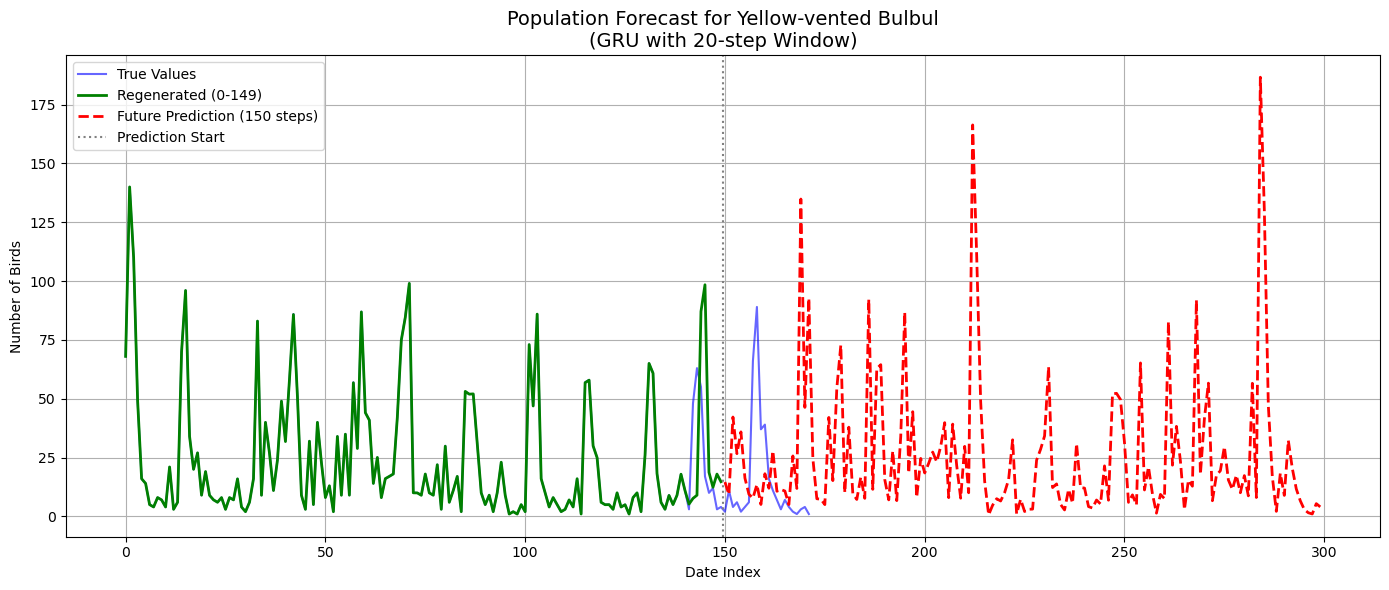

Model Performance Metrics of GRU with 20-step Window:
MSE: 97.1176
RMSE: 9.8548
MAE: 1.9236


In [8]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


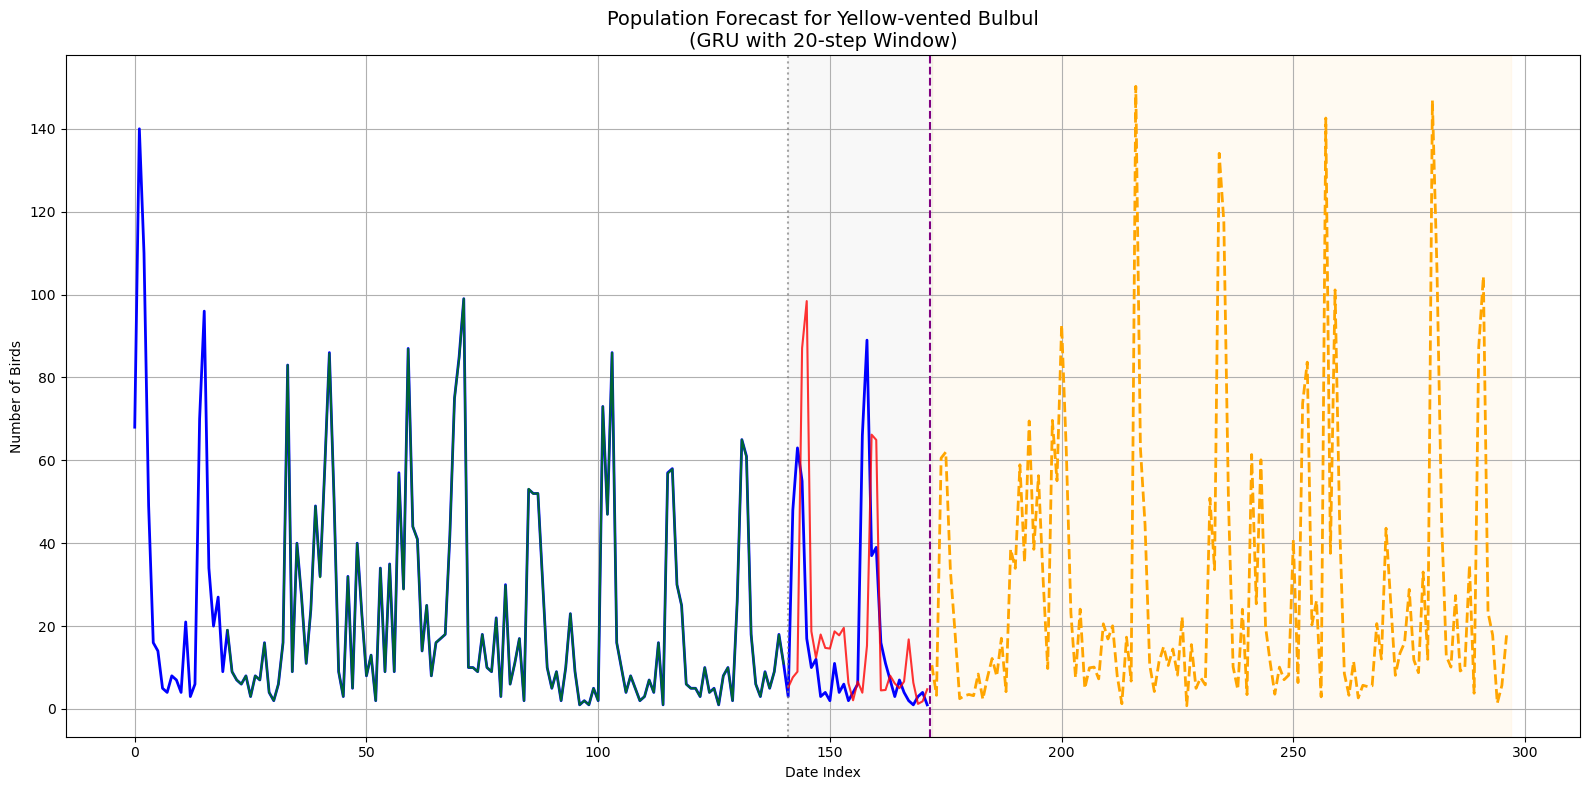


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 0.08
Test RMSE: 28.12
Training MAE: 0.04
Test MAE: 17.57


In [4]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))


print("\nModel Performance Metrics of GRU with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [ ]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 11.17
Step 2: 10.45
Step 3: 73.65
Step 4: 244.06
Step 5: 190.86
Step 6: 115.41
Step 7: 51.77
Step 8: 42.37
Step 9: 8.02
Step 10: 17.40
Step 11: 25.98
Step 12: 7.25
Step 13: 9.87
Step 14: 23.19
Step 15: 22.83
Step 16: 7.38
Step 17: 9.54
Step 18: 122.43
Step 19: 126.71
Step 20: 321.36
Step 21: 97.48
Step 22: 61.33
Step 23: 31.22
Step 24: 9.17
Step 25: 18.41
Step 26: 16.47
Step 27: 10.18
Step 28: 7.70
Step 29: 24.87
Step 30: 52.72
Step 31: 32.15
Step 32: 47.51
Step 33: 91.83
Step 34: 137.15
Step 35: 106.99
Step 36: 47.34
Step 37: 22.35
Step 38: 9.67
Step 39: 26.09
Step 40: 21.05
Step 41: 7.64
Step 42: 6.17
Step 43: 11.75
Step 44: 17.25
Step 45: 18.20
Step 46: 10.69
Step 47: 9.82
Step 48: 168.97
Step 49: 106.91
Step 50: 296.83
Step 51: 79.19
Step 52: 26.38
Step 53: 33.72
Step 54: 12.75
Step 55: 18.90
Step 56: 14.75
Step 57: 15.23
Step 58: 8.51
Step 59: 9.69
Step 60: 7.09
Step 61: 22.52
Step 62: 8.17
Step 63: 18.21
Step 64: 187.36
Step 65: 94.10
Step 

## **Window Size of 25**

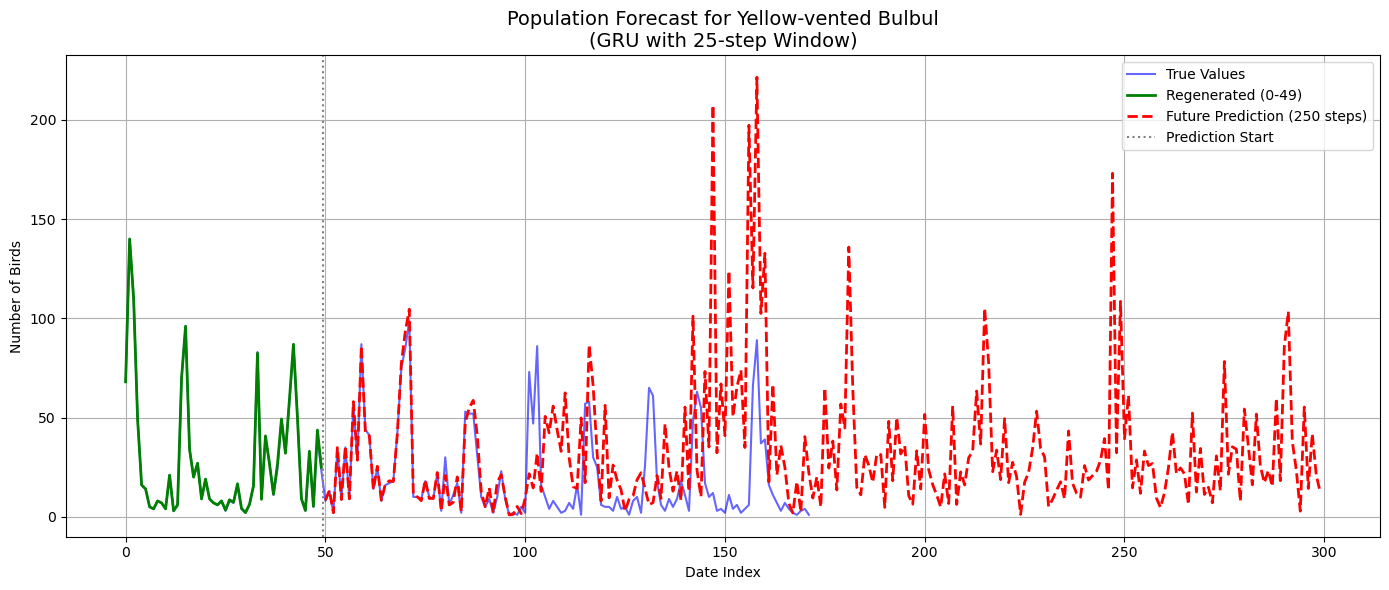

Model Performance Metrics of GRU with 25-step Window:
MSE: 1.2398
RMSE: 1.1135
MAE: 0.7416


In [12]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

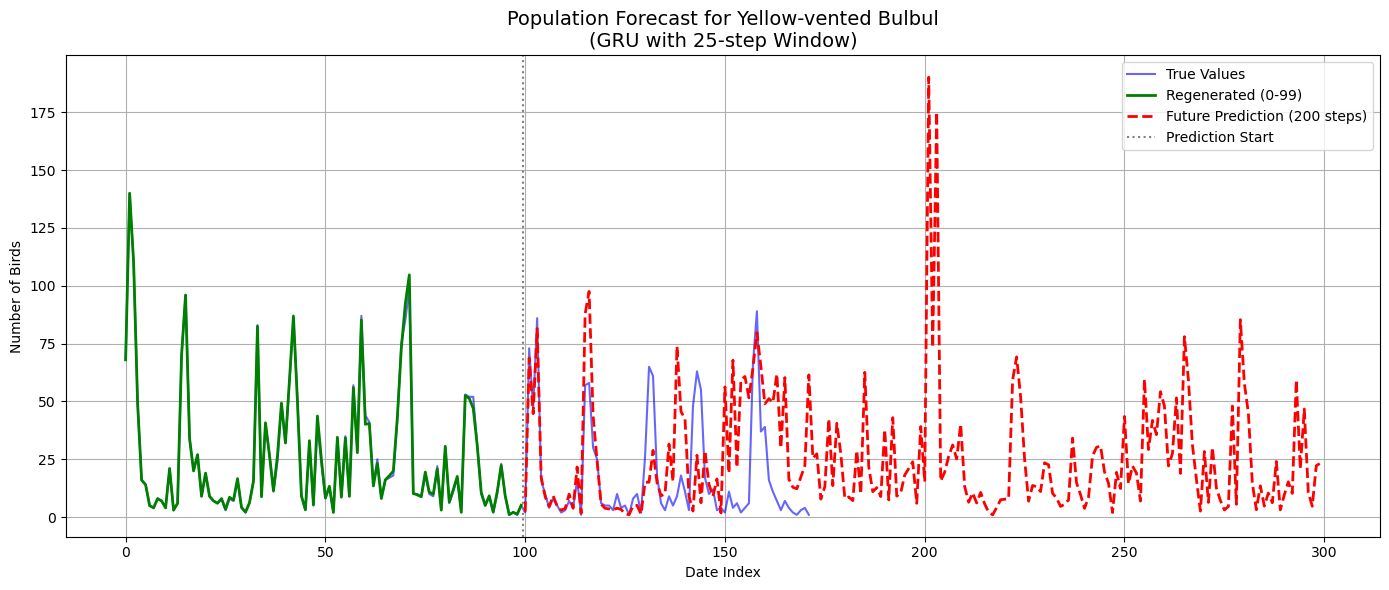

Model Performance Metrics of GRU with 25-step Window:
MSE: 2.4537
RMSE: 1.5664
MAE: 0.9081


In [13]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

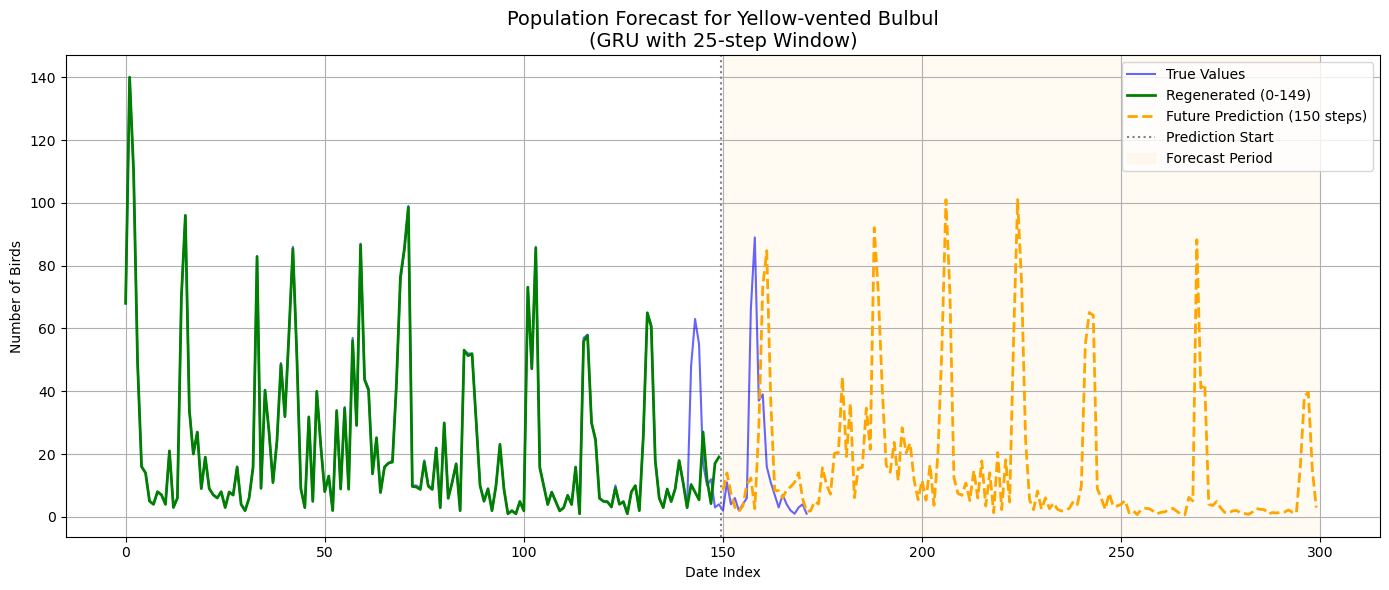

Model Performance Metrics of GRU with 25-step Window:
MSE: 60.1685
RMSE: 7.7568
MAE: 1.7217
MAPE: 11.44%


In [6]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


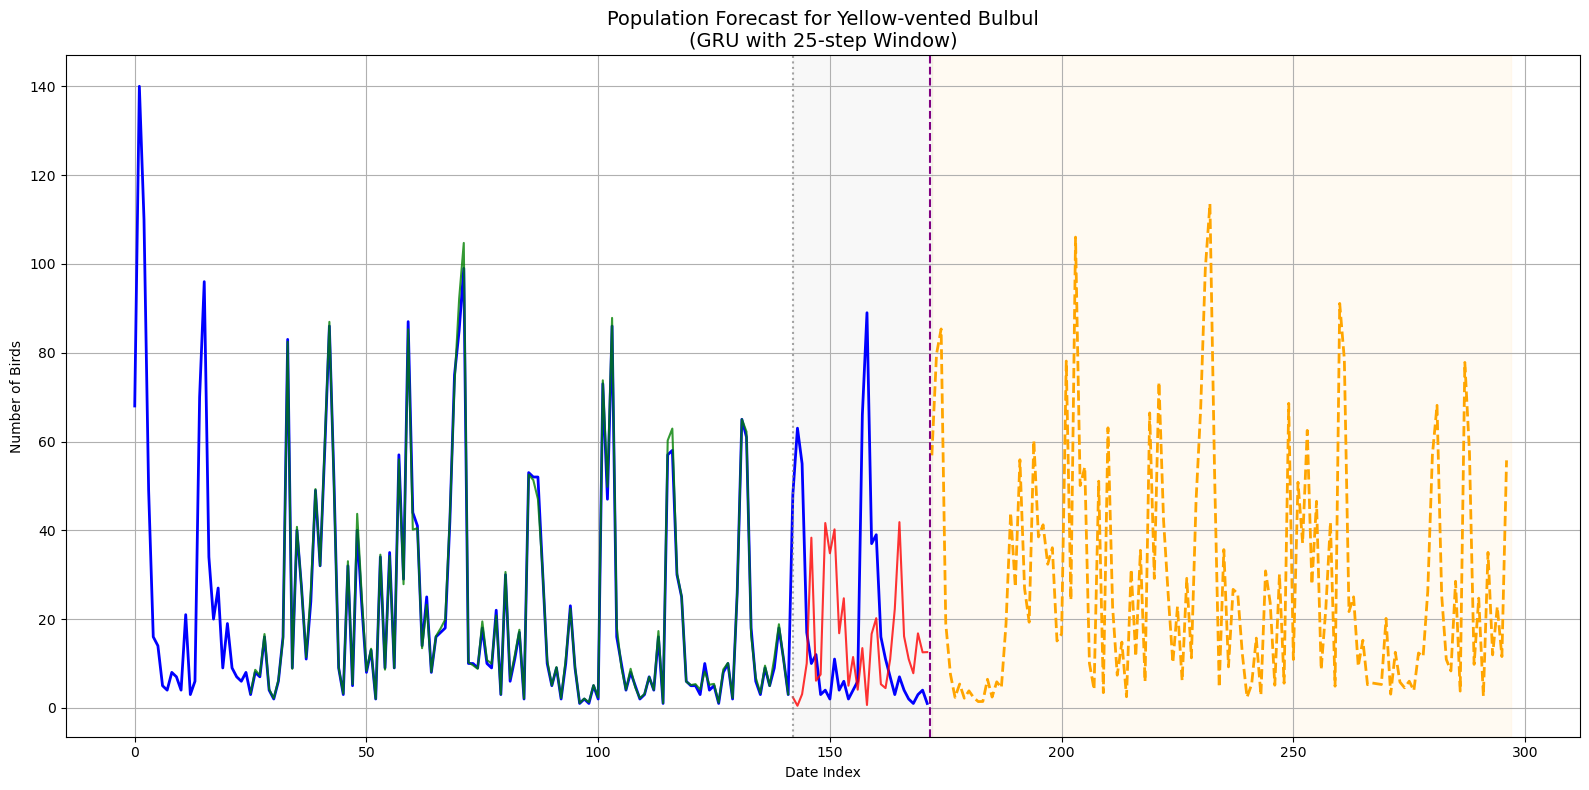


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 1.48
Test RMSE: 30.15
Training MAE: 0.88
Test MAE: 22.21


In [15]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))


print("\nModel Performance Metrics of GRU with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [16]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 56.88
Step 2: 79.65
Step 3: 85.35
Step 4: 18.96
Step 5: 7.63
Step 6: 2.38
Step 7: 5.38
Step 8: 2.18
Step 9: 3.85
Step 10: 2.34
Step 11: 1.43
Step 12: 1.45
Step 13: 6.45
Step 14: 2.45
Step 15: 5.87
Step 16: 4.55
Step 17: 18.93
Step 18: 43.94
Step 19: 27.22
Step 20: 55.89
Step 21: 26.93
Step 22: 19.30
Step 23: 60.24
Step 24: 38.52
Step 25: 41.24
Step 26: 32.36
Step 27: 36.08
Step 28: 15.08
Step 29: 16.66
Step 30: 78.12
Step 31: 24.27
Step 32: 106.03
Step 33: 50.08
Step 34: 54.26
Step 35: 10.04
Step 36: 4.15
Step 37: 51.06
Step 38: 3.43
Step 39: 63.08
Step 40: 22.76
Step 41: 7.37
Step 42: 14.82
Step 43: 2.51
Step 44: 31.20
Step 45: 11.57
Step 46: 35.49
Step 47: 5.94
Step 48: 66.44
Step 49: 29.16
Step 50: 73.37
Step 51: 42.14
Step 52: 25.42
Step 53: 10.18
Step 54: 22.80
Step 55: 6.13
Step 56: 29.19
Step 57: 11.26
Step 58: 46.52
Step 59: 67.37
Step 60: 98.81
Step 61: 113.54
Step 62: 53.08
Step 63: 4.64
Step 64: 35.66
Step 65: 9.24
Step 66: 26.70
Step 

## **window size of 30**

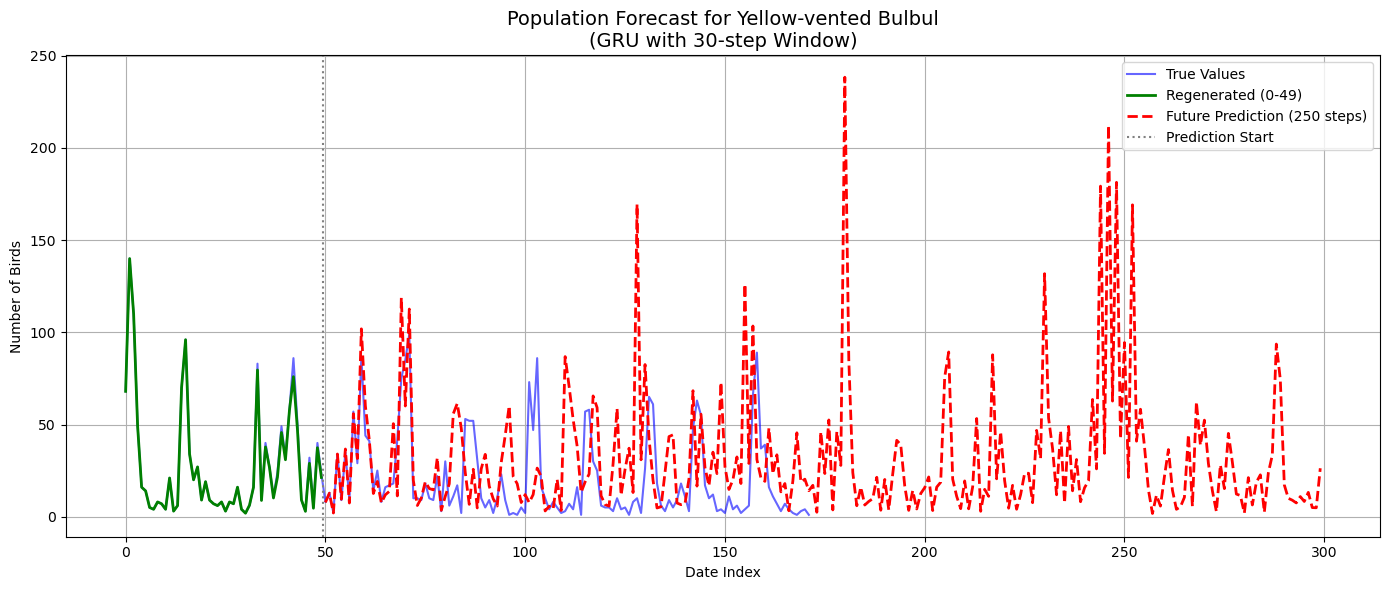

Model Performance Metrics of GRU with 30-step Window:
MSE: 8.5205
RMSE: 2.9190
MAE: 1.8197


In [19]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

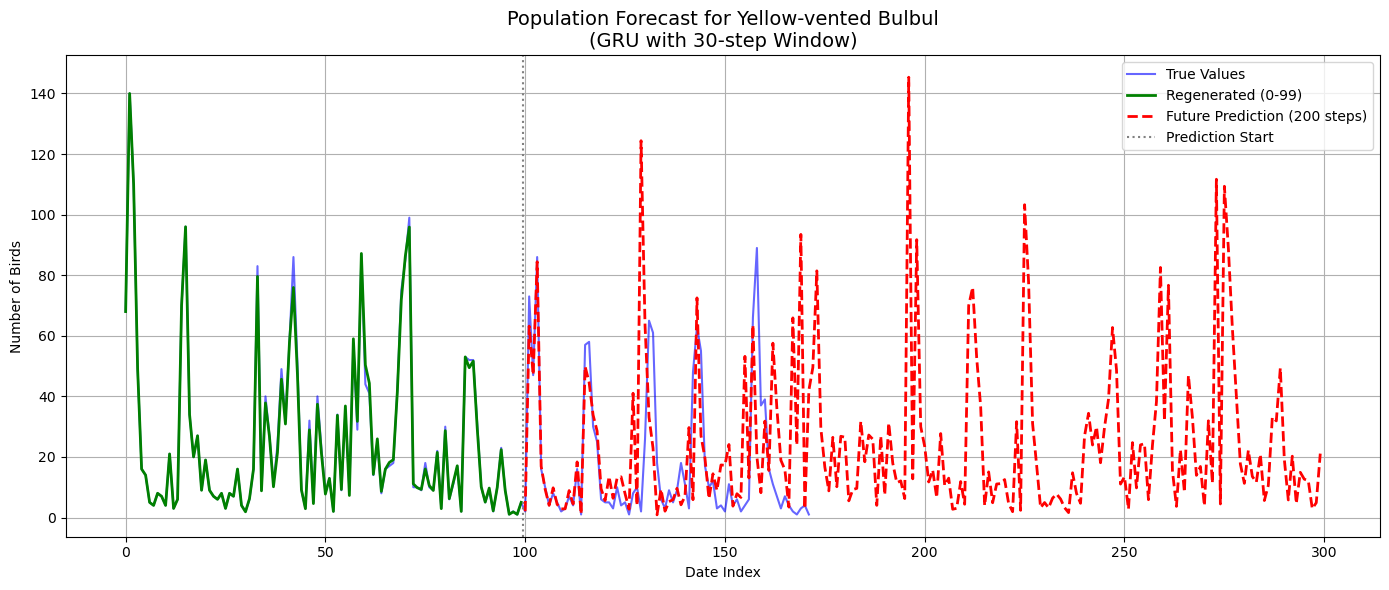

Model Performance Metrics of GRU with 30-step Window:
MSE: 4.0363
RMSE: 2.0091
MAE: 1.1592


In [20]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

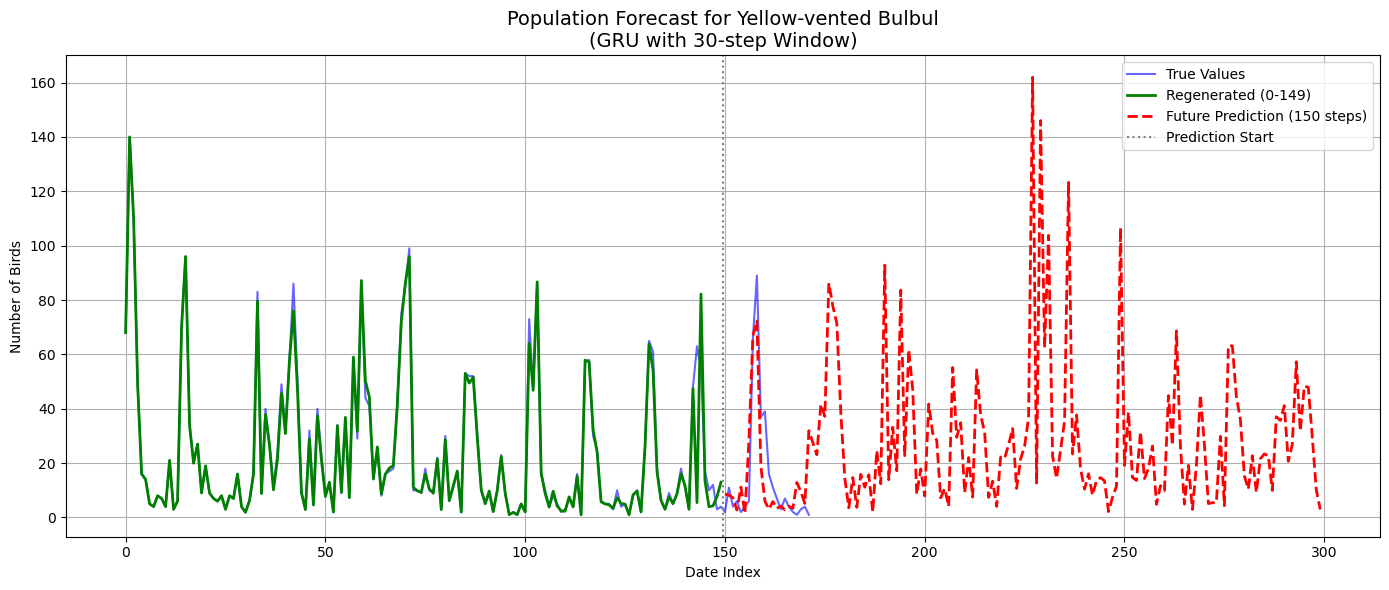

Model Performance Metrics of GRU with 30-step Window:
MSE: 39.1833
RMSE: 6.2597
MAE: 1.9872


In [21]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


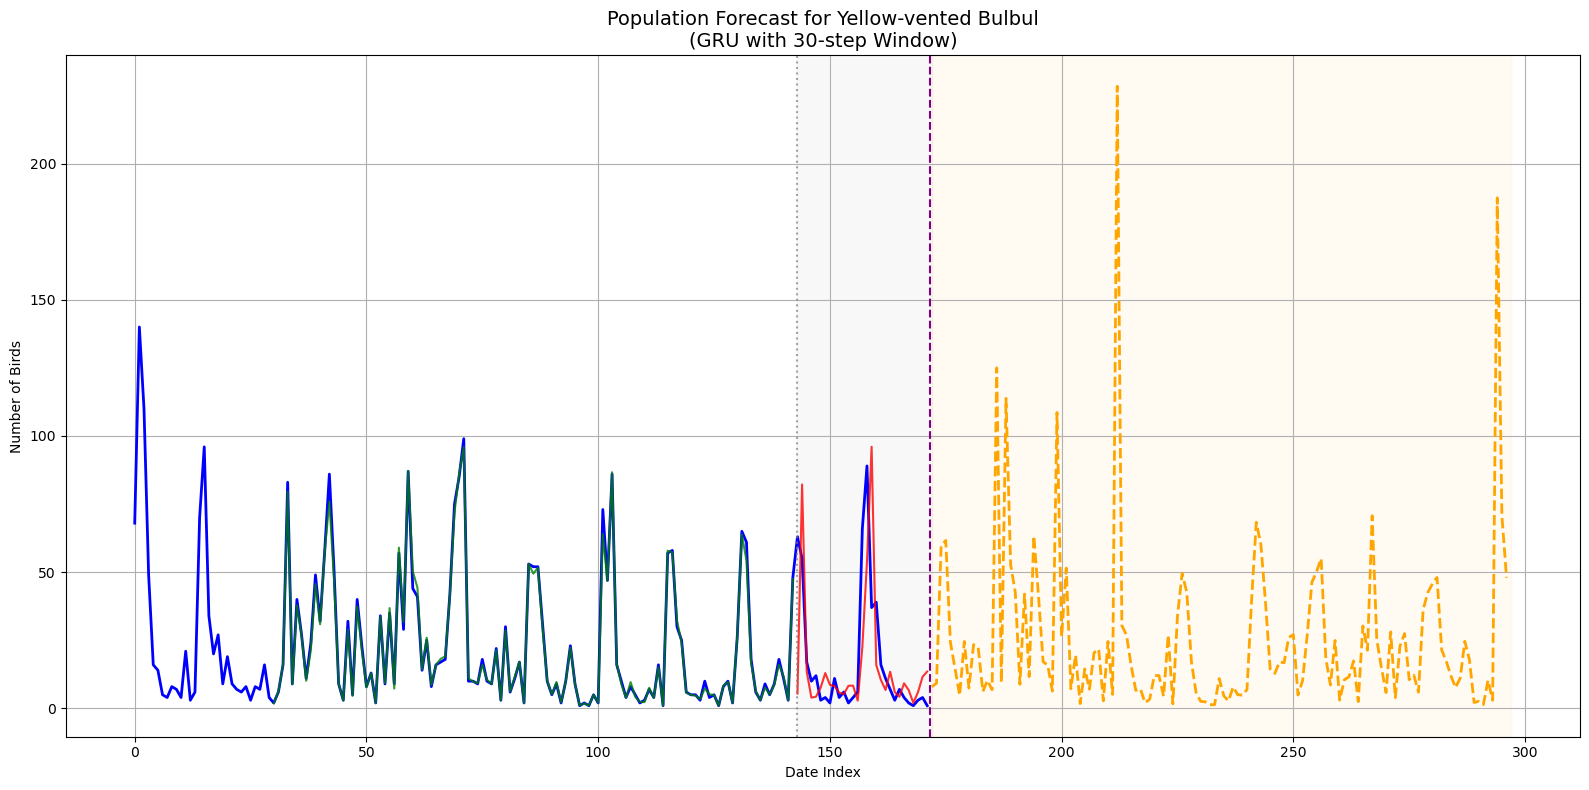


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 1.98
Test RMSE: 20.27
Training MAE: 1.09
Test MAE: 12.35


In [22]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))


print("\nModel Performance Metrics of GRU with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [23]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 7.94
Step 2: 9.24
Step 3: 59.80
Step 4: 61.65
Step 5: 24.28
Step 6: 14.61
Step 7: 4.83
Step 8: 24.57
Step 9: 7.47
Step 10: 23.43
Step 11: 22.27
Step 12: 6.19
Step 13: 10.28
Step 14: 6.87
Step 15: 125.01
Step 16: 9.52
Step 17: 113.81
Step 18: 52.73
Step 19: 42.62
Step 20: 8.84
Step 21: 41.96
Step 22: 11.67
Step 23: 63.34
Step 24: 41.51
Step 25: 17.14
Step 26: 15.87
Step 27: 6.34
Step 28: 108.61
Step 29: 26.27
Step 30: 51.54
Step 31: 7.23
Step 32: 19.56
Step 33: 1.76
Step 34: 14.48
Step 35: 7.07
Step 36: 20.45
Step 37: 21.79
Step 38: 2.77
Step 39: 24.56
Step 40: 5.14
Step 41: 228.35
Step 42: 30.40
Step 43: 26.92
Step 44: 15.72
Step 45: 6.63
Step 46: 7.18
Step 47: 2.06
Step 48: 3.35
Step 49: 12.04
Step 50: 12.07
Step 51: 4.45
Step 52: 26.96
Step 53: 1.67
Step 54: 34.03
Step 55: 49.56
Step 56: 42.67
Step 57: 17.19
Step 58: 5.85
Step 59: 2.60
Step 60: 2.40
Step 61: 1.36
Step 62: 1.35
Step 63: 10.95
Step 64: 4.60
Step 65: 2.74
Step 66: 7.86
Step 67: 5.

## **Window Size of 50**

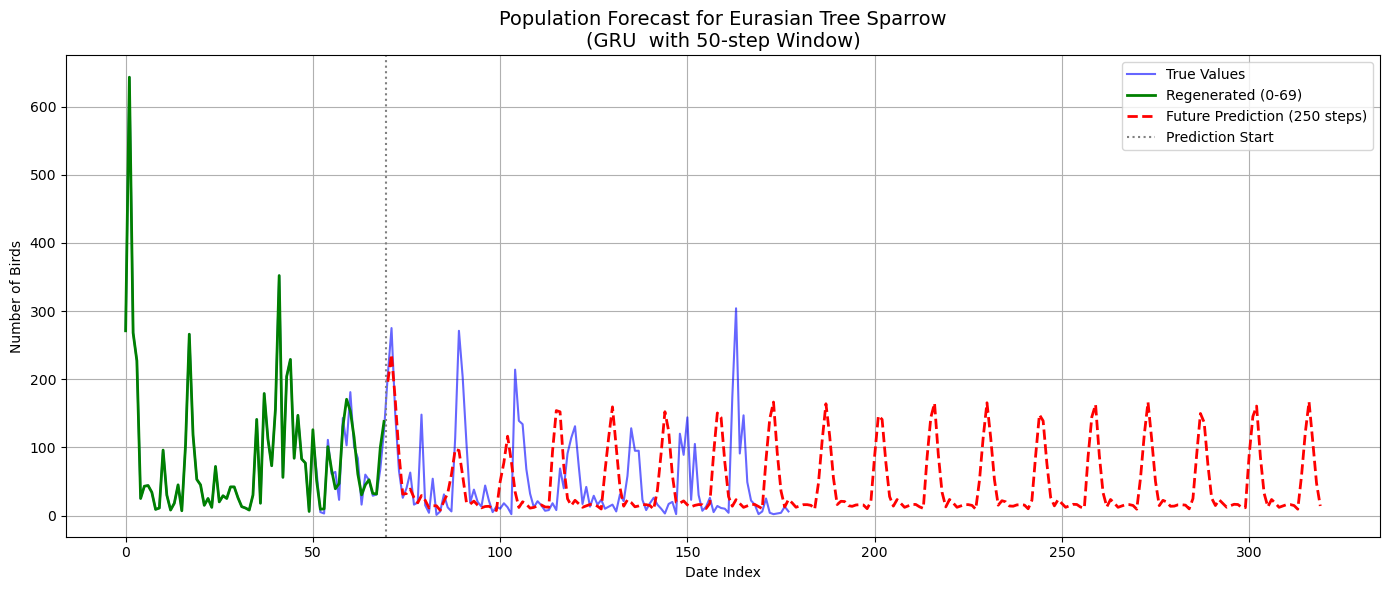

Model Performance Metrics of GRU with 50-step Window:
MSE: 474.1151
RMSE: 21.7742
MAE: 16.0866


In [ ]:
regenerate_points = 70
future_steps = 250

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

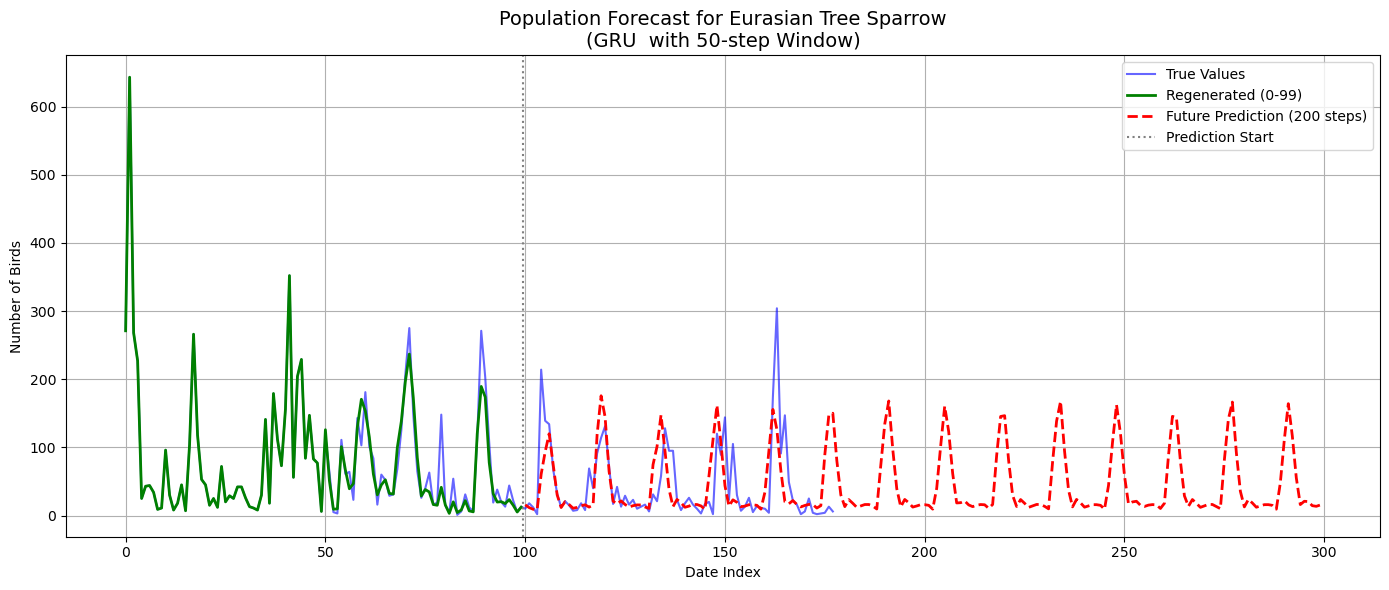

Model Performance Metrics of GRU with 50-step Window:
MSE: 698.4619
RMSE: 26.4284
MAE: 16.4904


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

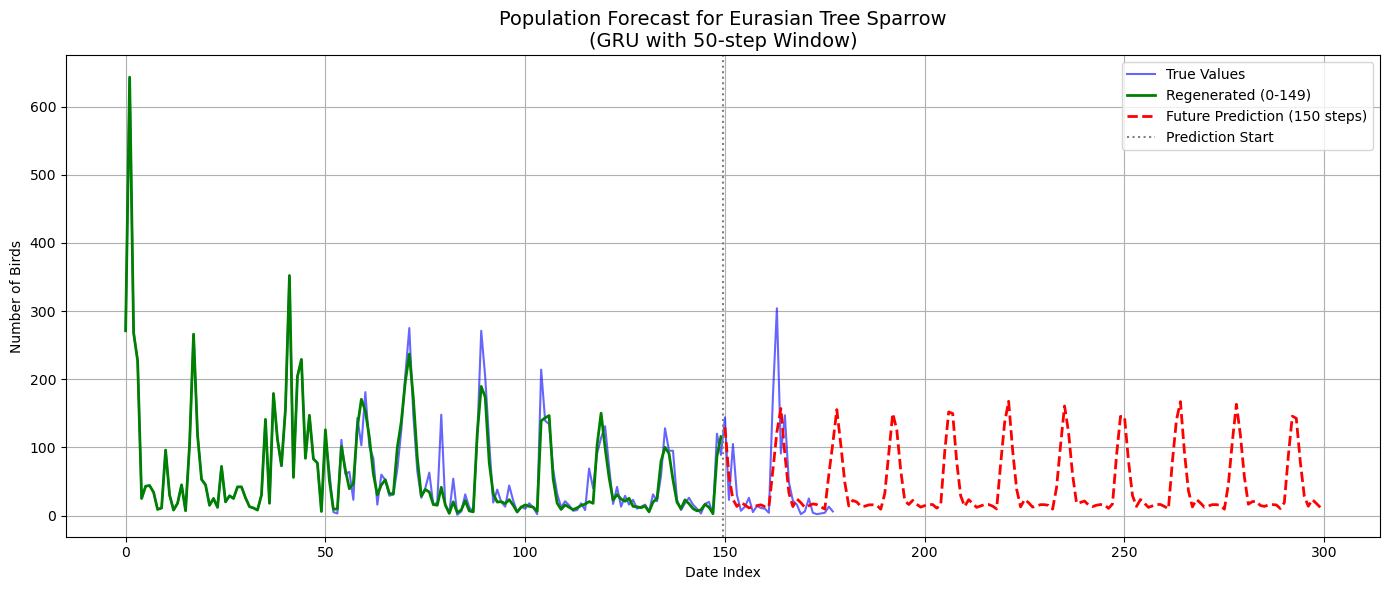

Model Performance Metrics of GRU with 50-step Window:
MSE: 527.2347
RMSE: 22.9616
MAE: 14.3023


In [ ]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])



# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0



# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0



# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# -------------------------
# metrics
# -------------------------
true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)


print(f"Model Performance Metrics of GRU with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


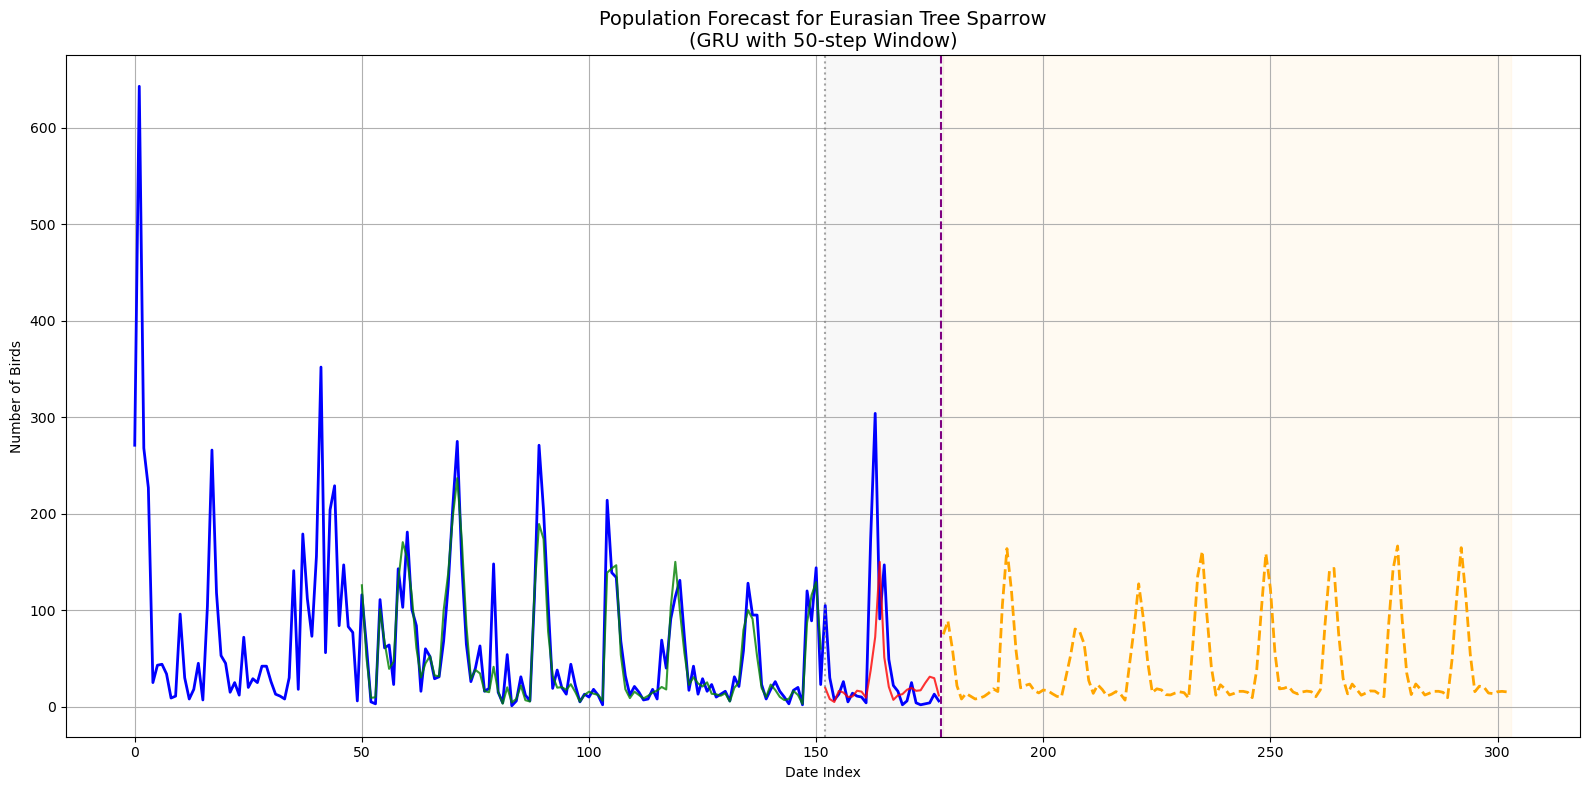


Model Performance Metrics of GRU with {window_size}-step Window:
Training RMSE: 23.08
Test RMSE: 60.84
Training MAE: 14.53
Test MAE: 32.55


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))



# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values


# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f"Population Forecast for {most_frequent_bird}\n(GRU with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))


print("\nModel Performance Metrics of GRU with {window_size}-step Window:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {mean_absolute_error(Y_train_inv, train_pred_inv):.2f}")
print(f"Test MAE: {mean_absolute_error(Y_test_inv, test_pred_inv):.2f}")

In [16]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 75.02
Step 2: 88.90
Step 3: 59.84
Step 4: 21.70
Step 5: 7.99
Step 6: 13.73
Step 7: 10.89
Step 8: 8.01
Step 9: 8.84
Step 10: 10.77
Step 11: 14.13
Step 12: 18.54
Step 13: 15.71
Step 14: 105.45
Step 15: 163.89
Step 16: 120.03
Step 17: 58.51
Step 18: 19.57
Step 19: 21.99
Step 20: 23.47
Step 21: 16.81
Step 22: 14.29
Step 23: 17.35
Step 24: 16.59
Step 25: 13.48
Step 26: 10.70
Step 27: 10.10
Step 28: 31.21
Step 29: 52.76
Step 30: 80.53
Step 31: 77.93
Step 32: 65.15
Step 33: 27.38
Step 34: 13.82
Step 35: 22.70
Step 36: 17.72
Step 37: 11.14
Step 38: 12.85
Step 39: 15.68
Step 40: 13.12
Step 41: 6.83
Step 42: 44.37
Step 43: 81.43
Step 44: 127.38
Step 45: 92.48
Step 46: 45.91
Step 47: 14.74
Step 48: 18.53
Step 49: 17.43
Step 50: 12.53
Step 51: 12.15
Step 52: 14.11
Step 53: 15.44
Step 54: 14.55
Step 55: 8.96
Step 56: 69.71
Step 57: 135.53
Step 58: 161.13
Step 59: 96.02
Step 60: 41.12
Step 61: 11.96
Step 62: 22.73
Step 63: 18.43
Step 64: 12.20
Step 65: 13.77
S

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,917 (261.40 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,612 (174.27 KB)